In [176]:
DF_PATH = '../data/processed/preprocessed_data.pkl'

ROLE_COLS      = ['DevType']
TECH_COLS      = ['LanguageHaveWorkedWith',
                  'DatabaseHaveWorkedWith',
                  'WebframeHaveWorkedWith',
                  'MiscTechHaveWorkedWith',
                  'ToolsTechHaveWorkedWith']
EXCULDE_ROLES = [
    'Other (please specify):',
    'Student',
    'Designer',
    'Educator',
    'Marketing or sales professional',
    'Engineering manager',
    'Senior Executive (C-Suite',
    'Product manager',
    ' etc.)']

EXPORT_FEATURES_DIR = "../data/processed/"
FIG_DIR = "../reports/figures"


In [197]:
# Load packages
import pandas as pd 
import numpy as np
import logging
import pickle
import os
import yaml
import warnings

import plotly 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.manifold import TSNE

from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN

from sklearn.metrics import silhouette_score

warnings.filterwarnings("ignore")
pd.options.display.max_rows = 1000

## Functions

In [3]:
def one_hot_encoding(data_frame, cols_names):
    """
    perform one hot encoding to a pandas series
    parameters:
        data_frame(pd.DataFrame):string DataFrame 
        cols_names(list): list of strings containing the names of the columns 
                          that are needed to be encoded 
    Returns:
        (pd.DataFrame) : a DataFrame containing the encoded data 
    """
    encoded_dfs_dict = {}
    for col in cols_names:
        binarizer = MultiLabelBinarizer()
        encoded_df = pd.DataFrame(binarizer.fit_transform(data_frame[col]), columns=binarizer.classes_, index=data_frame[col].index)
        encoded_dfs_dict[col] = encoded_df
    
    return pd.concat(encoded_dfs_dict, axis=1)

In [78]:
def choose_best_n_clusters(cluster_model, data, range_n_clusters=[10,30], **model_params):
    """
    given a clustering model and range of numbers it chooses the number of clusters that maximizes silhoutte
    Parameters:
        cluster_model(sklearn.cluster): the model to be evaluated
        range_n_clusters(list): the range of number of clusters to be evaluated - default: [10,30]
        data(pd.DataFrame): the data that the model will be fitted on
        **model_params: parameters to be passed to the model
    Returns:
        best_model(sklearn.cluster): best cluster model
        silhoutte_scores(list): all the scores of the evaluated models
    """
    best_model = None
    silhoutte_scores=[]
    lower_n_cluster, upper_n_cluster = range_n_clusters[0], range_n_clusters[1]
    for n_clusters in range(lower_n_cluster, upper_n_cluster):
        model = cluster_model(n_clusters=n_clusters, **model_params)
        labels = model.fit_predict(data)
        
        silhoutte_avg = silhouette_score(data, labels)
        silhoutte_scores.append(silhoutte_avg)
        
        if silhoutte_avg >= np.max(silhoutte_scores):
            best_model = model
        
    return best_model, silhoutte_scores

## Feature Engineering

#### Loading the data and preprocessing

In [170]:
raw_df = pd.read_pickle(DF_PATH)
ohe_df = one_hot_encoding(raw_df, ROLE_COLS+TECH_COLS)

### Dimensionality Reduction

we will use **t-sne** dimensionality reduction algorithm in order to gain more insights about the structure of the data

#### preparing the data

In [171]:
ohe_skills = ohe_df.drop('DevType', axis=1).copy()
std_skills = StandardScaler().fit_transform(ohe_skills)

#### T-sne

In [8]:
tsne_projection = TSNE(n_components=2, 
                       perplexity=3,
                       learning_rate=0.01,
                       init='pca', 
                       method='barnes_hut', 
                       n_jobs=2, 
                       n_iter=10**10,
                       random_state=0).fit_transform(std_skills.T)

tsne_projection = pd.DataFrame(tsne_projection, index=ohe_skills.columns)

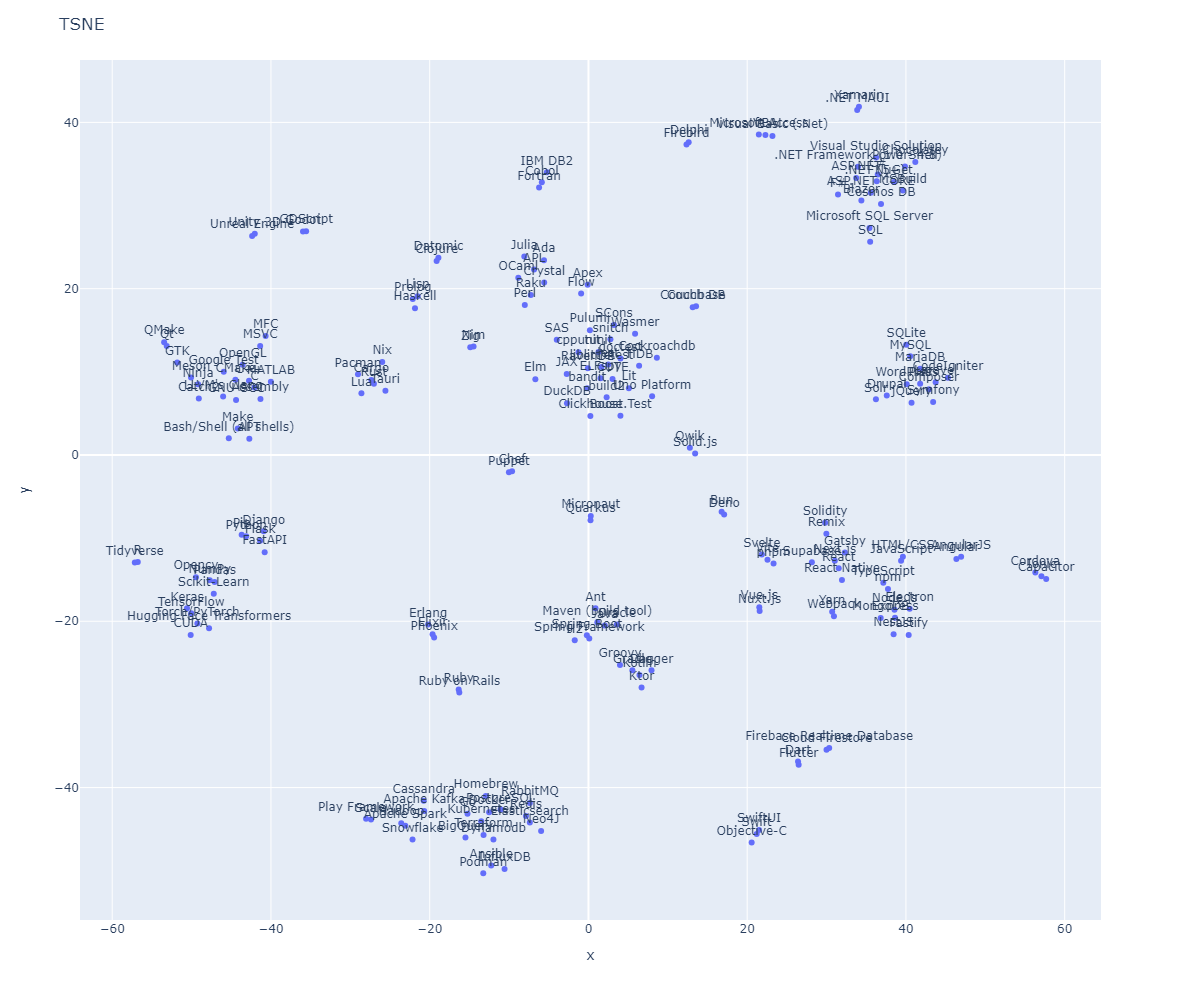

In [49]:
fig = px.scatter(x=tsne_projection[0], y=tsne_projection[1], text=tsne_projection.droplevel(0).index)
fig.update_traces(textposition='top center')
fig.update_layout(height=1000, width=1000, title_text='TSNE')
fig.show()

fig.write_html(os.path.join(FIG_DIR, 'tsne_scatter_plot.html'))

we can see that **t-sne** was able to capture skill groups that looks promising. we will further investigate this by trying clustering this data 

### Clustering

In [79]:
range_n_clusters = [10, 30]
agg_model, agg_silhoutte_scores = choose_best_n_clusters(AgglomerativeClustering, tsne_projection, range_n_clusters=range_n_clusters)
kmeans_model, kmeans_silhoutte_scores = choose_best_n_clusters(KMeans, tsne_projection, range_n_clusters=range_n_clusters)

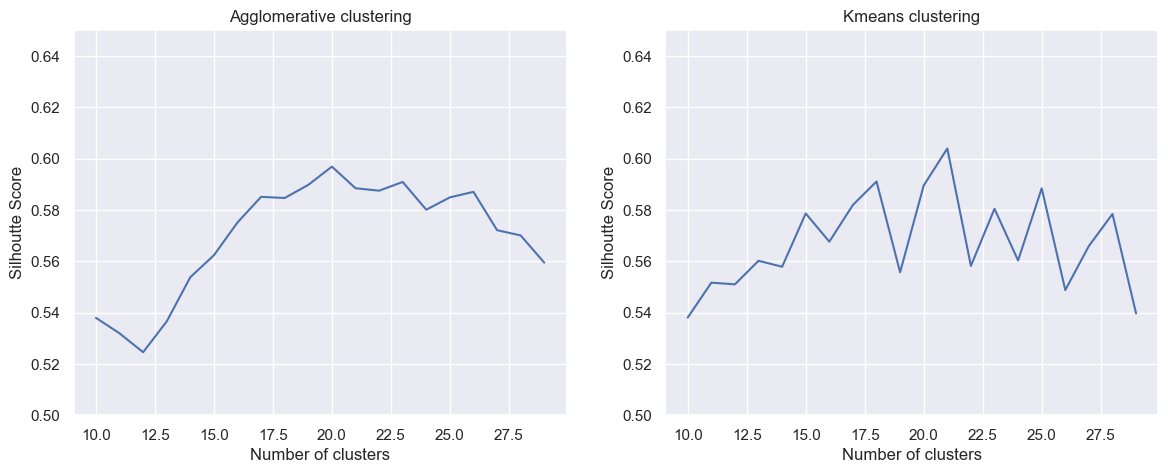

In [87]:
list_n_cluster = list(range(range_n_clusters[0], range_n_clusters[1]))
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))

sns.lineplot(x=list_n_cluster, y=agg_silhoutte_scores, ax=ax1)
ax1.set_title('Agglomerative clustering') 
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Silhoutte Score')
ax1.set_ylim([.5,.65])

sns.lineplot(x=list_n_cluster, y=kmeans_silhoutte_scores, ax=ax2)
ax2.set_title('Kmeans clustering') 
ax2.set_xlabel('Number of clusters')
ax2.set_ylabel('Silhoutte Score')
ax2.set_ylim([.5,.65])

plt.show()

In [100]:
agg_labels = ['skill_group_'+str(label) for label in agg_model.labels_]
kmeans_labels = ['skill_group_'+str(label) for label in kmeans_model.labels_]

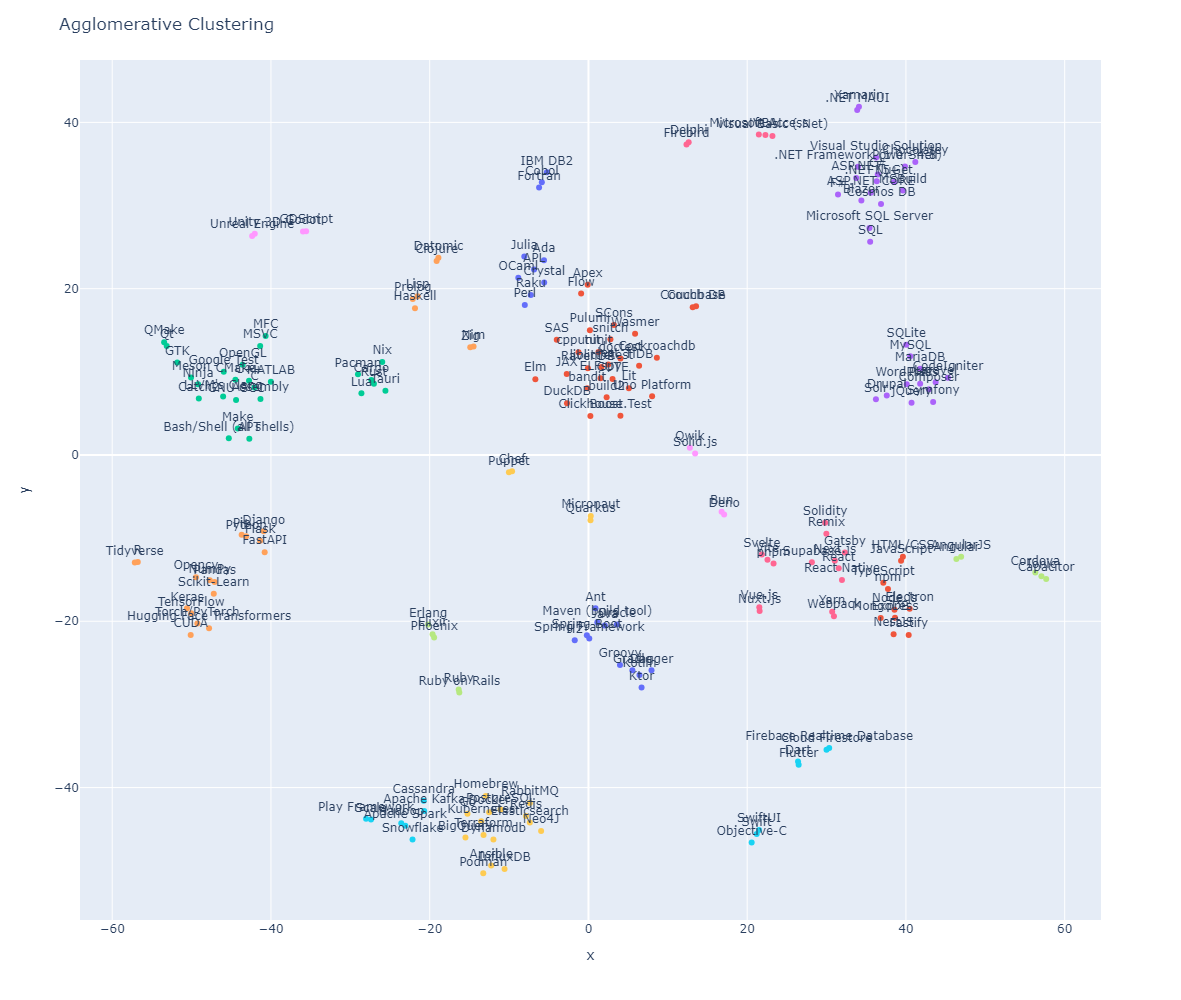

In [102]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.droplevel(0).index, 
                 color=agg_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=1000, width=1200, title_text='Agglomerative Clustering', showlegend=False)
fig.show()

fig.write_html(os.path.join(FIG_DIR, 'tsne_agglomerative_clustering_scatter_plot.html'))

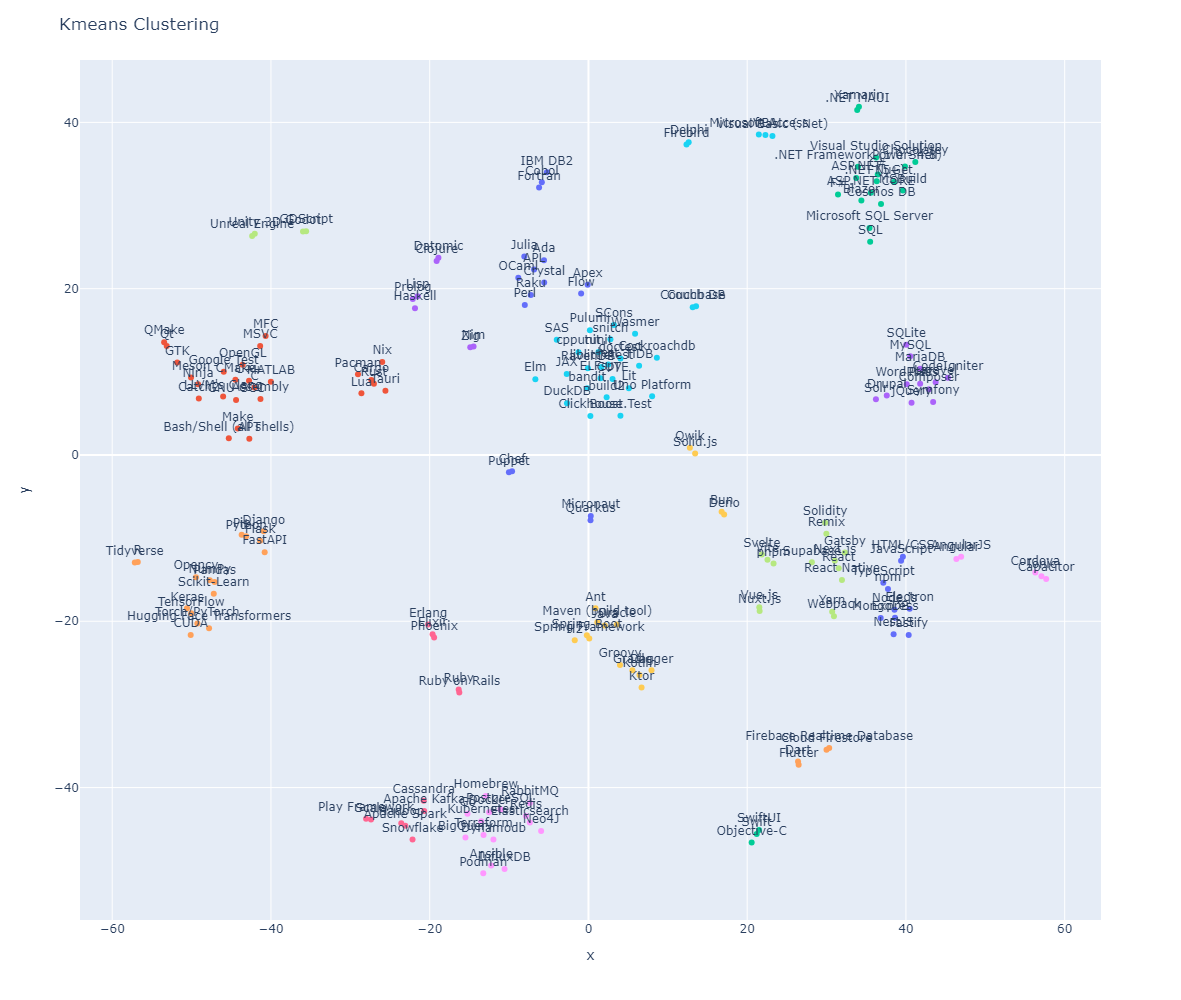

In [103]:
fig = px.scatter(x=tsne_projection[0], 
                 y=tsne_projection[1], 
                 text=tsne_projection.droplevel(0).index, 
                 color=kmeans_labels)
fig.update_traces(textposition='top center')
fig.update_layout(height=1000, width=1200, title_text='Kmeans Clustering', showlegend=False)
fig.show()
fig.write_html(os.path.join(FIG_DIR, 'tsne_kmeans_clustering_scatter_plot.html'))

we can see that both of the two models have very similar results and able to cluster the skills accurately (kmeans has higher number of clusters and slightly higher silhoutter score)

In [113]:
skills_clusters = tsne_projection.index.droplevel(0).to_series().groupby(kmeans_labels).apply(list)

In [116]:
for cluster, skills in skills_clusters.items():
    print(cluster)
    print(skills)

skill_group_0
['Elixir', 'Erlang', 'Ruby', 'Phoenix', 'Ruby on Rails']
skill_group_1
['SAS', 'Clickhouse', 'Cockroachdb', 'Couch DB', 'Couchbase', 'DuckDB', 'RavenDB', 'TiDB', 'Elm', 'Lit', 'JAX', 'Uno Platform', 'Boost.Test', 'CUTE', 'ELFspy', 'Pulumi', 'SCons', 'Wasmer', 'bandit', 'build2', 'cppunit', 'doctest', 'lest', 'liblittletest', 'snitch', 'tunit']
skill_group_10
['Objective-C', 'Swift', 'SwiftUI']
skill_group_11
['APL', 'Ada', 'Apex', 'Cobol', 'Crystal', 'Flow', 'Fortran', 'Julia', 'OCaml', 'Perl', 'Raku', 'IBM DB2']
skill_group_12
['Deno', 'Qwik', 'Solid.js', 'Bun']
skill_group_13
['Delphi', 'VBA', 'Visual Basic (.Net)', 'Firebird', 'Microsoft Access']
skill_group_14
['GDScript', 'Godot', 'Unity 3D', 'Unreal Engine']
skill_group_15
['Scala', 'Cassandra', 'Snowflake', 'Play Framework', 'Apache Kafka', 'Apache Spark', 'Hadoop']
skill_group_16
['Solidity', 'Supabase', 'Gatsby', 'Next.js', 'Nuxt.js', 'React', 'Remix', 'Svelte', 'Vue.js', 'React Native', 'Vite', 'Webpack', 'Yarn'

### Creating new features

In [137]:
new_features = []

for skill_group, skills in skills_clusters.items():
    cluster_sum = ohe_skills.droplevel(0, axis=1)[skills_clusters[skill_group]].sum(axis=1)
    cluster_sum.name = skill_group
    new_features.append(cluster_sum)

fe_clusterd_skills = pd.concat(new_features, axis=1)

In [140]:
fe_clusterd_skills.head()

,skill_group_0,skill_group_1,skill_group_10,skill_group_11,skill_group_12,skill_group_13,skill_group_14,skill_group_15,skill_group_16,skill_group_17,...,skill_group_19,skill_group_2,skill_group_20,skill_group_3,skill_group_4,skill_group_5,skill_group_6,skill_group_7,skill_group_8,skill_group_9
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,9,0,...,1,4,0,0,0,2,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,2,0,0,2,0,3,0,0,0,0
3,2,0,0,0,0,0,0,0,5,0,...,0,5,0,1,1,3,0,2,0,0
4,0,0,0,0,0,0,0,0,5,0,...,0,8,0,0,0,4,0,0,0,0


## Exporting new features

In [141]:
new_features_path = os.path.join(EXPORT_FEATURES_DIR, 'fe_cluster_skills.pkl')
fe_clusterd_skills.to_pickle(new_features_path)

In [143]:
description_path = os.path.join(EXPORT_FEATURES_DIR, 'fe_cluster_skills_description.yaml')
with open(description_path, 'w') as output_file:
    yaml.dump(skills_clusters.to_dict(), output_file)

### Excluding rare & useless roles

In [179]:
for role in EXCULDE_ROLES:
    ohe_df.drop(('DevType', role), axis=1, inplace=True)

In [183]:
ohe_df['DevType'].columns

Index([' QA or test', ' VP', ' back-end', ' data',
       ' desktop or enterprise applications',
       ' embedded applications or devices', ' front-end', ' full-stack',
       ' game or graphics', ' mobile', ' site reliability',
       'Academic researcher', 'Blockchain', 'Cloud infrastructure engineer',
       'Data or business analyst',
       'Data scientist or machine learning specialist',
       'Database administrator', 'DevOps specialist', 'Developer',
       'Developer Advocate', 'Developer Experience', 'Engineer',
       'Hardware Engineer', 'Project manager', 'Research & Development role',
       'Scientist', 'Security professional', 'System administrator'],
      dtype='object')

### Filtering data

In [189]:
freq_roles = ohe_df[ROLE_COLS].sum(axis=1)
freq_skills = ohe_df[TECH_COLS].sum(axis=1)

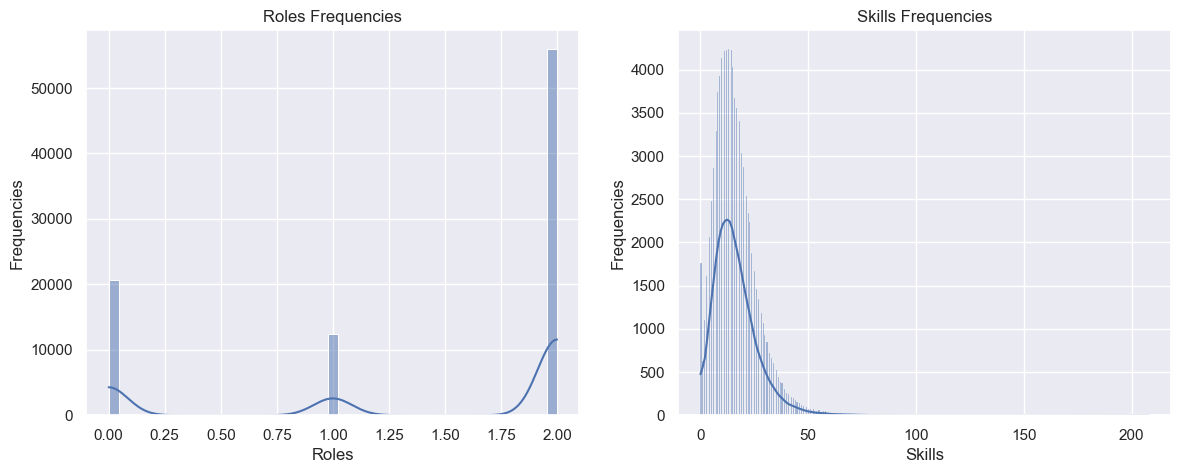

In [190]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(14,5))

sns.histplot(freq_roles, ax=ax1, kde=True)
ax1.set_title('Roles Frequencies') 
ax1.set_xlabel('Roles')
ax1.set_ylabel('Frequencies')

sns.histplot(freq_skills, ax=ax2, kde=True)
ax2.set_title('Skills Frequencies') 
ax2.set_xlabel('Skills')
ax2.set_ylabel('Frequencies')

plt.show()

In [210]:
ROLES_RANGE = [1,2]
TECH_RANGE  = [3,35]

In [212]:
roles_mask = (freq_roles>=ROLES_RANGE[0]) & (freq_roles<=ROLES_RANGE[1])
tech_mask = (freq_skills>=TECH_RANGE[0]) & (freq_skills<=TECH_RANGE[1])
filter_mask = roles_mask & tech_mask

In [213]:
filtered_encoded_df = ohe_df.loc[filter_mask].copy()
filtered_fe_df = fe_clusterd_skills.loc[filter_mask].copy()

### Exporting final data

In [217]:
filtered_fe_df.columns = pd.MultiIndex.from_product([['skills_clusters'], fe_clusterd_skills.columns])

In [220]:
final_df = pd.concat([filtered_encoded_df,filtered_fe_df], axis=1)

In [221]:
final_df.to_pickle(os.path.join(EXPORT_FEATURES_DIR,'merged_cleaned_data.pkl'))